# Module 1.10: Lie Detector 6 — When Diagnostics Lie

> **Goal:** Select 6 anchor metrics, synthesize into 2 scores.

Module 1.09 gave us 45+ diagnostics per series—too many to act on. Now we select 6 "Anchor Metrics" that separate real signal from noise, and learn when even those can lie.

---

## 1. Setup

In [12]:
import warnings
import numpy as np
import pandas as pd
from scipy import stats

import forecast_foundations as ff
from tsforge.eda.diagnostics import compute_structure_chaos_scores

# NEW: Plotly-based functions
from tsforge.plots.core.scatter import plot_scatter
from tsforge.plots.evaluation.diagnostics import plot_distribution

warnings.filterwarnings('ignore')

env = ff.setup_notebook()
DATA_DIR = env.DATA_DIR

✓ Setup complete | Root: real-world-forecasting-foundations | Notebook: 1.10_lie_detector_v2 | Data: /Users/lindsaytruong/forecast-academy/real-world-forecasting-foundations/data | Cache: on


---

## 2. Load Data

In [19]:
# Load diagnostics from 1.09
diagnostics = pd.read_parquet('/Users/lindsaytruong/forecast-academy/real-world-forecasting-foundations/data/.cache/diagnostics_99914b932bd3.parquet')

# Load weekly data for time series plots later (optional)
weekly_df = pd.read_parquet(DATA_DIR / 'output' / 'data' / '1.08_data_preparation_output.parquet')

In [20]:
# Quick check
diagnostics.head(3)

,unique_id,hurst,series_length,unitroot_pp,unitroot_kpss,hw_alpha,hw_beta,hw_gamma,stability,nperiods,...,diff1_acf10,diff2_acf1,diff2_acf10,seas_acf1,adi,item_id,dept_id,cat_id,store_id,state_id
0,FOODS_1_001_CA_1,0.772978,283,-238.087160,0.464131,0.250347,0.0,0.0,0.165089,1,...,0.302900,-0.685183,0.539962,-0.111695,1.105469,FOODS_1_001,FOODS_1,FOODS,CA_1,CA
1,FOODS_1_001_CA_2,0.827633,283,-203.367626,0.796027,0.267957,0.0,0.0,0.171234,1,...,0.248609,-0.667034,0.555232,0.039438,1.105469,FOODS_1_001,FOODS_1,FOODS,CA_2,CA
2,FOODS_1_001_CA_3,0.797488,283,-253.771210,0.836479,0.151329,0.0,0.0,0.123224,1,...,0.293540,-0.639856,0.514713,-0.042894,1.118577,FOODS_1_001,FOODS_1,FOODS,CA_3,CA


---

## 3. The Lie Detector 6

| Camp | Metric | Question | High Value Means |
|------|--------|----------|------------------|
| **Structure** | `trend` | Is there directional movement? | Strong up/down pattern |
| **Structure** | `seasonal_strength` | Is there a repeating cycle? | Reliable weekly/yearly pattern |
| **Structure** | `x_acf1` | Does last week predict this week? | High persistence |
| **Chaos** | `entropy` | How random is the sequence? | Unpredictable behavior |
| **Chaos** | `adi` | How sparse is demand? | Long gaps between non-zero values |
| **Chaos** | `lumpiness` | Does variance change over time? | Unstable, regime-shifting behavior |

In [21]:
# The Lie Detector 6
STRUCTURE_COLS = ['trend', 'seasonal_strength', 'x_acf1']
CHAOS_COLS = ['entropy', 'adi', 'lumpiness']
LD6_COLS = STRUCTURE_COLS + CHAOS_COLS

In [22]:
# Keep LD6 + identifiers + hierarchy + cv2 (for S-B)
id_cols = ['unique_id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
keep_cols = [c for c in id_cols if c in diagnostics.columns] + LD6_COLS

ld6_df = diagnostics[keep_cols].copy()
ld6_df.head()

,unique_id,item_id,dept_id,cat_id,store_id,state_id,trend,seasonal_strength,x_acf1,entropy,adi,lumpiness
0,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0.204450,0.376623,0.333107,0.850729,1.105469,0.360278
1,FOODS_1_001_CA_2,FOODS_1_001,FOODS_1,FOODS,CA_2,CA,0.223280,0.439298,0.395002,0.843529,1.105469,0.212689
2,FOODS_1_001_CA_3,FOODS_1_001,FOODS_1,FOODS,CA_3,CA,0.162804,0.384099,0.249157,0.895521,1.118577,0.058872
3,FOODS_1_001_CA_4,FOODS_1_001,FOODS_1,FOODS,CA_4,CA,0.110839,0.479389,0.274281,0.873170,1.276018,0.049412
4,FOODS_1_001_TX_1,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,0.260977,0.376637,0.256359,0.866836,1.200855,0.105567


---

## 4. When Diagnostics Lie

The LD6 works as a **system**, not 6 isolated numbers. When chaos metrics are high, structure metrics become unreliable.

### 4.1 Trend × ADI: When Trend Lies

<Axes: title={'center': 'Trend × ADI: When Trend Lies'}, xlabel='Trend', ylabel='Adi'>

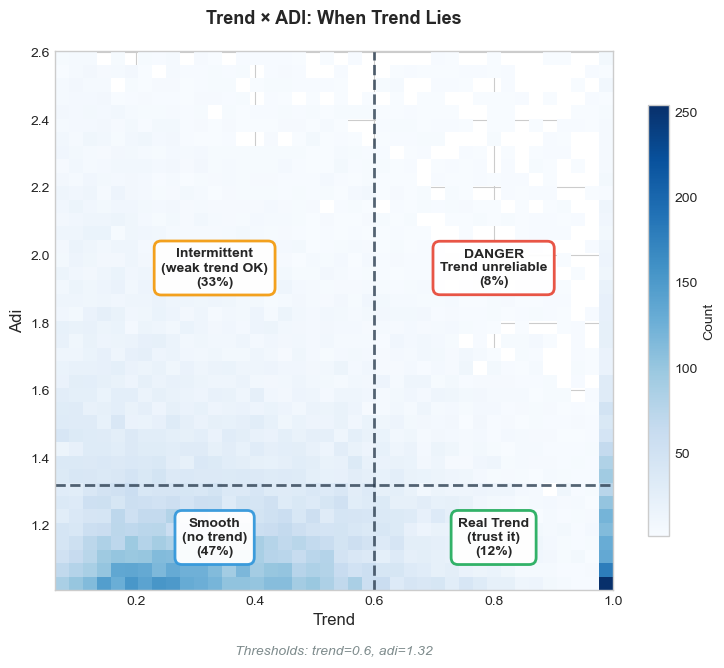

In [ ]:
plot_scatter(
    ld6_df, x='trend', y='adi',
    kind='density',
    use_metric_defaults=True,
    show_threshold_annotation=True,
    style={"title": "Trend × ADI: When Trend Lies"},
)

### 4.2 Seasonality × ADI: When Seasonality Lies

<Axes: title={'center': 'Seasonality × ADI: When Seasonality Lies'}, xlabel='Seasonal Strength', ylabel='Adi'>

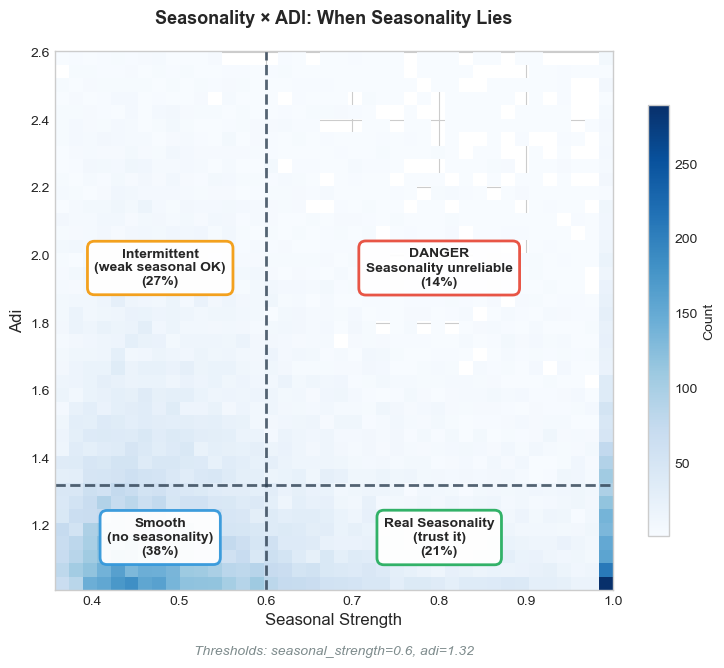

In [ ]:
plot_scatter(
    ld6_df, x='seasonal_strength', y='adi',
    kind='density',
    use_metric_defaults=True,
    show_threshold_annotation=True,
    style={"title": "Seasonal Strength × ADI: When Seasonality Lies"},
)

### 4.3 Seasonality × Entropy: Patterns in Noise?

<Axes: title={'center': 'Seasonality × Entropy: Does Chaos Override Seasonality?'}, xlabel='Seasonal Strength', ylabel='Entropy'>

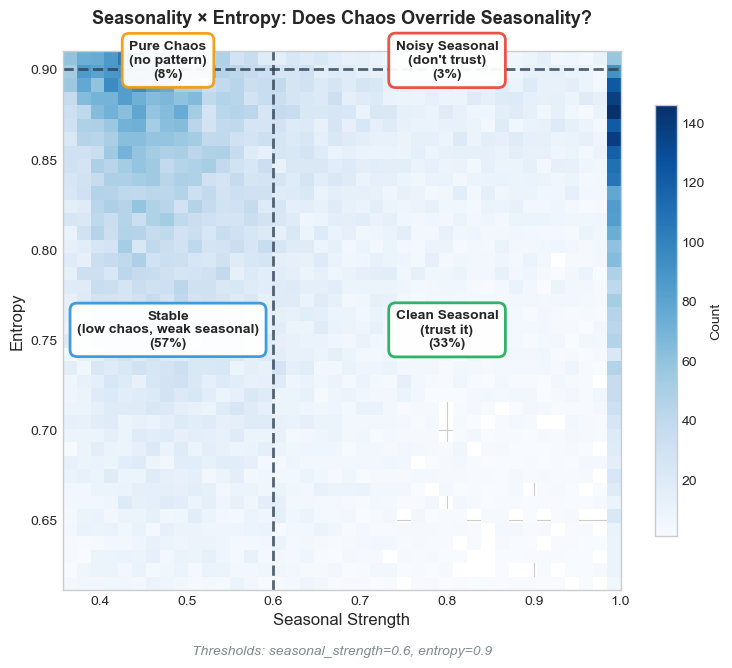

In [ ]:
plot_scatter(
    ld6_df, x='seasonal_strength', y='entropy',
    kind='density',
    use_metric_defaults=True,
    show_threshold_annotation=True,
    style={"title": "Seasonal Strength × Entropy: Does Chaos Override Seasonality?"},
)

---

## 5. Compute Structure & Chaos Scores

We collapse 6 metrics into 2 scores using `compute_structure_chaos_scores()`:
- **Structure Score**: Average of normalized (trend, seasonality, acf1) — higher = more learnable
- **Chaos Score**: Average of normalized (entropy, ADI, lumpiness) — higher = less trustworthy

The function handles:
- Clipping outliers (default: 95th percentile for chaos metrics)
- Min-max normalization to [0, 1]
- Weighted averaging (optional)

In [23]:
# Compute structure and chaos scores with defaults (LD6 metrics)
scores_df = compute_structure_chaos_scores(
    ld6_df,
    clip_quantile=0.95,      # Cap outliers at 95th percentile
    clip_cols="chaos",       # Only clip chaos metrics
    normalize="minmax",      # Scale to [0, 1]
)


In [24]:
scores_df

,unique_id,item_id,dept_id,cat_id,store_id,state_id,trend,seasonal_strength,x_acf1,entropy,...,adi_clipped,lumpiness_clipped,trend_norm,seasonal_strength_norm,x_acf1_norm,entropy_norm,adi_norm,lumpiness_norm,structure_score,chaos_score
0,FOODS_1_001_CA_1,FOODS_1_001,FOODS_1,FOODS,CA_1,CA,0.204450,0.376623,0.333107,0.850729,...,1.105469,0.360278,0.204450,0.251314,0.535291,0.906000,0.065787,0.485038,0.330351,0.485609
1,FOODS_1_001_CA_2,FOODS_1_001,FOODS_1,FOODS,CA_2,CA,0.223280,0.439298,0.395002,0.843529,...,1.105469,0.212689,0.223280,0.326588,0.582389,0.894589,0.065787,0.286341,0.377419,0.415572
2,FOODS_1_001_CA_3,FOODS_1_001,FOODS_1,FOODS,CA_3,CA,0.162804,0.384099,0.249157,0.895521,...,1.118577,0.058872,0.162804,0.260293,0.471410,0.976992,0.073964,0.079258,0.298169,0.376738
3,FOODS_1_001_CA_4,FOODS_1_001,FOODS_1,FOODS,CA_4,CA,0.110839,0.479389,0.274281,0.873170,...,1.276018,0.049412,0.110839,0.374737,0.490528,0.941567,0.172170,0.066522,0.325368,0.393420
4,FOODS_1_001_TX_1,FOODS_1_001,FOODS_1,FOODS,TX_1,TX,0.260977,0.376637,0.256359,0.866836,...,1.200855,0.105567,0.260977,0.251331,0.476890,0.931528,0.125286,0.142124,0.329733,0.399646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,HOUSEHOLD_2_516_TX_2,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,TX_2,TX,0.045244,0.416273,0.066308,0.907876,...,1.331754,0.118658,0.045244,0.298935,0.332274,0.996574,0.206935,0.159748,0.225484,0.454419
30486,HOUSEHOLD_2_516_TX_3,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,TX_3,TX,0.228420,0.425547,0.241863,0.871741,...,1.944828,0.114614,0.228420,0.310072,0.465860,0.939303,0.589348,0.154304,0.334784,0.560985
30487,HOUSEHOLD_2_516_WI_1,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_1,WI,0.114466,0.325640,0.098170,0.895532,...,2.364407,0.183489,0.114466,0.190083,0.356518,0.977009,0.851066,0.247029,0.220356,0.691701
30488,HOUSEHOLD_2_516_WI_2,HOUSEHOLD_2_516,HOUSEHOLD_2,HOUSEHOLD,WI_2,WI,0.057683,0.483008,0.016654,0.906232,...,2.603175,0.163548,0.057683,0.379084,0.294489,0.993969,1.000000,0.220183,0.243752,0.738051


### 5.1 Score Distributions

In [25]:
# Plot score distributions
plot_distribution(
    scores_df,
    columns=['structure_score', 'chaos_score'],
    bins=50,
    wrap=2,
    show_kde=True,
    show_median=True,
    style={"title": "Structure & Chaos Score Distributions"},
)

---

## 6. Save Output

In [26]:
# Save scores for downstream modules
scores_df.to_parquet(DATA_DIR / 'output' / '1.10_scores.parquet', index=False)
print(f"Saved: {DATA_DIR / 'output' / '1.10_scores.parquet'}")

Saved: /Users/lindsaytruong/forecast-academy/real-world-forecasting-foundations/data/output/1.10_scores.parquet
